In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from pow.models.llama31 import Llama
from pow.compute.utils import (
    count_params,
    get_rng,
    initialize_model_weights_from_rng,
    get_random_emb,
    get_uniform_vector_on_sphere
)
from pow.compute.stats import (
    estimate_R_from_experiment
)
import numpy as np
import torch

torch.set_default_dtype(torch.float32)



In [3]:
def get_model(
    hash_: str,
):
    model = Llama.build(
        params_path="../resources/llama31-8b/params.json",
        tokenizer_path="../resources/llama31-8b/tokenizer.model",
        max_seq_len=1024,
        max_batch_size=1,
        flash=False,
        model_parallel_size=1,
        seed=1,
    )
    model.model.eval()
    model.model.requires_grad_(False)

    count_params(model.model)
    rng = get_rng(str(hash_), 4)
    initialize_model_weights_from_rng(model.model, rng)
    model.to_cuda()
    
    return model

In [4]:
model = get_model(
    "some-shared-hash"
)

Creating model...
Loaded in 2.15 seconds
Total number of parameters: 0.28B


0it [00:00, ?it/s]

/home/morgachev/.cache/pypoetry/virtualenvs/proof-of-work-q10pOv6v-py3.11/lib/python3.11/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


In [5]:
def get_input(
    public_key: str,
    nonce: str,
    batch_size: int = 256,
    seq_len: int = 16,
):
    emb = get_random_emb(
        seed_string=f"{public_key}__nonce{nonce}",
        batch_size=batch_size,
        seq_len=seq_len,
        dim=model.model.params.dim
    )
    emb = torch.tensor(
        emb,
        dtype=torch.get_default_dtype()
    ).cuda()
    return emb


def get_target(     
    public_key: str,
):
    rng = get_rng(f"{public_key}_target", 1)
    target = get_uniform_vector_on_sphere(
        rng,
        dim=model.model.params.vocab_size,
        batch_size=1
    )[0]
    return target


In [6]:
PUBLIC_KEY = "public_key"
target = get_target(PUBLIC_KEY)

In [7]:
emb = get_input(PUBLIC_KEY, 42)
output_np = model.model.forward_embedding(
    emb, 0
)[:, -1, :].cpu().numpy()
output_np = output_np / np.linalg.norm(output_np, axis=1, keepdims=True)

In [8]:
output_np

array([[ 0.01900132,  0.00163192,  0.00487959, ...,  0.03257369,
         0.00791722,  0.00465338],
       [-0.01372835, -0.00750037, -0.01366138, ...,  0.02290291,
        -0.0099112 , -0.01024604],
       [-0.02920376,  0.02591676, -0.01757283, ..., -0.00805948,
        -0.00679525, -0.01049313],
       ...,
       [ 0.03938323, -0.0130425 ,  0.00364423, ...,  0.01540805,
        -0.004827  ,  0.00255735],
       [-0.00659008,  0.00364918,  0.00274073, ...,  0.01564374,
         0.00856094, -0.00415729],
       [-0.00081201,  0.02775027, -0.00529778, ..., -0.00271196,
         0.01545186,  0.00116677]], dtype=float32)

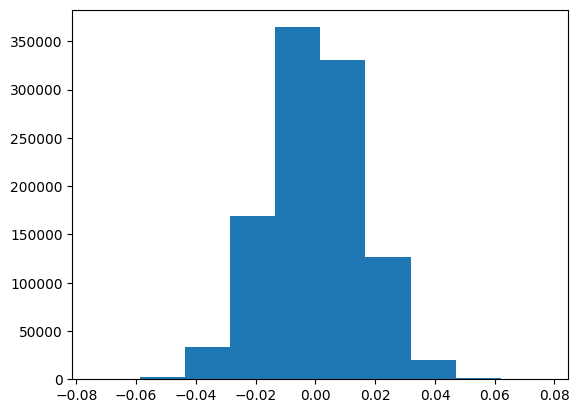

In [9]:
import matplotlib.pyplot as plt

def plot_tesor_distribution(
    t: np.ndarray
):
    plt.hist(t.flatten())
    plt.show()

plot_tesor_distribution(output_np)

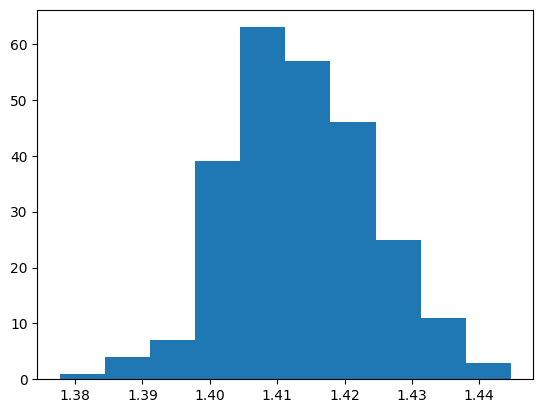

In [13]:
def compute_distance(
    output_np: np.ndarray,
    target: np.ndarray,
):
    return np.linalg.norm(
        output_np - target,
        axis=1
    )

distances = compute_distance(
    output_np,
    target
)

plt.hist(distances)
plt.show()

In [14]:
!nvidia-smi

Fri Oct  4 06:15:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P4                       On  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0              24W /  75W |    954MiB /  7680MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [31]:
# Example usage:
n = 4096
P = 0.0001
R_estimated = estimate_R_from_experiment(n, P, num_samples=100000)
print(f"Estimated R from experiment: {R_estimated}")

Estimated R from experiment: 1.3722405606823325


In [32]:
all_distances = []
for i in range(400):
    emb = get_input(PUBLIC_KEY, i)
    output_np = model.model.forward_embedding(
        emb, 0
    )[:, -1, :].cpu().numpy()
    output_np = output_np / np.linalg.norm(output_np, axis=1, keepdims=True)
    distances = compute_distance(
        output_np,
        target
    )
    all_distances.extend(distances)


In [33]:
R_estimated = 1.3722405606823325

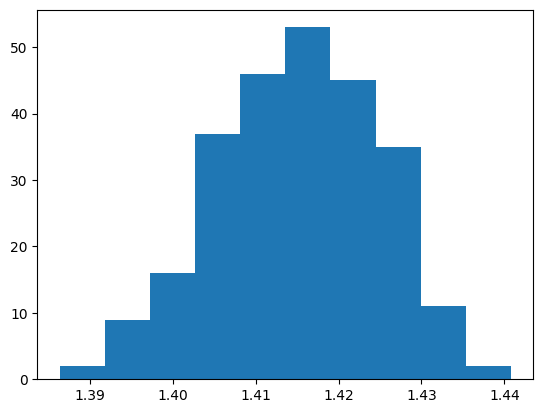

np.float64(6.8359375e-05)

In [34]:
all_distances = np.array(all_distances)
plt.hist(distances)
plt.show()

(all_distances < R_estimated).sum() / len(all_distances)



In [35]:
1 / ((all_distances < R_estimated).sum() / len(all_distances))

np.float64(14628.571428571428)

In [36]:
len(all_distances)

102400